# 1. Thư viện

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# 2. Thu thập và xử lý dữ liệu

In [2]:
from google.colab import drive
drive.mount('/content/drive')
input_csv = "/content/drive/MyDrive/Goc/consolidated_traffic_data.csv"
df = pd.read_csv(input_csv)
df = df.dropna().reset_index(drop=True)

# Tạo nhãn nhị phân VPN vs Non-VPN
df["vpn_label"] = df["traffic_type"].apply(
    lambda x: 1 if str(x).startswith("VPN") else 0
)

# Trộn dữ liệu
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Phân bố nhãn VPN vs Non-VPN:")
print(df["vpn_label"].value_counts())

feature_cols = [
    'duration','total_fiat','total_biat','min_fiat','min_biat',
    'max_fiat','max_biat','mean_fiat','mean_biat',
    'flowPktsPerSecond','flowBytesPerSecond',
    'min_flowiat','max_flowiat','mean_flowiat','std_flowiat',
    'min_active','mean_active','max_active','std_active',
    'min_idle','mean_idle','max_idle','std_idle'
]

X = df[feature_cols].values
y = df["vpn_label"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Mounted at /content/drive
Phân bố nhãn VPN vs Non-VPN:
vpn_label
1    28886
0    28710
Name: count, dtype: int64


# 3. Trực quan hóa nhãn

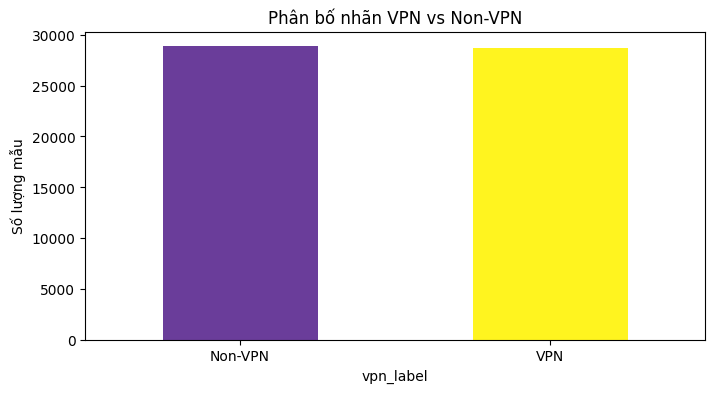

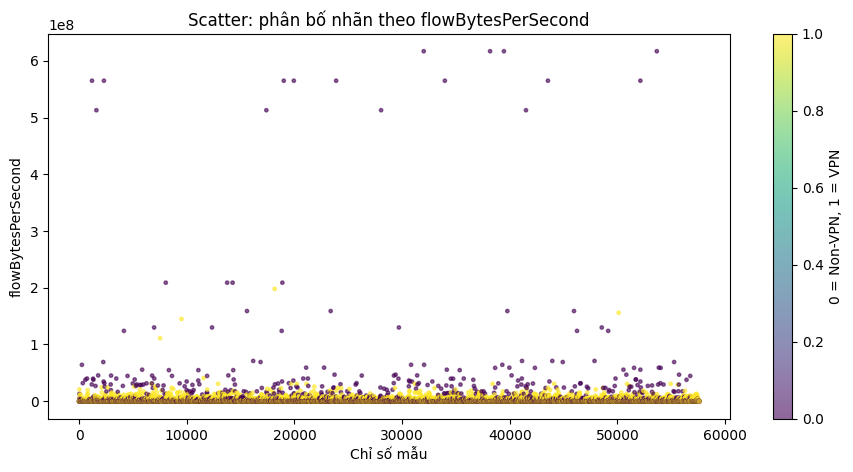

In [3]:
plt.figure(figsize=(8,4))
df["vpn_label"].value_counts().plot(
    kind="bar", color=["#6a3d9a","#fff41f"]
)
plt.title("Phân bố nhãn VPN vs Non-VPN")
plt.xticks([0,1], ["Non-VPN", "VPN"], rotation=0)
plt.ylabel("Số lượng mẫu")
plt.show()


plt.figure(figsize=(11,5))
plt.scatter(
    df.index,
    df["flowBytesPerSecond"],
    c=df["vpn_label"],
    cmap="viridis",
    s=6,
    alpha=0.6
)
plt.title("Scatter: phân bố nhãn theo flowBytesPerSecond")
plt.xlabel("Chỉ số mẫu")
plt.ylabel("flowBytesPerSecond")
plt.colorbar(label="0 = Non-VPN, 1 = VPN")
plt.show()

# 4. Chia dữ liệu

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Số mẫu train / test:", X_train.shape[0], X_test.shape[0])

Số mẫu train / test: 46076 11520


# 5. Hàm đo thời gian

In [5]:
def train_and_measure(model, X_train, y_train):
    t0 = time.time()
    model.fit(X_train, y_train)
    t1 = time.time()
    return t1 - t0

def test_and_measure(model, X_test):
    t0 = time.time()
    y_pred = model.predict(X_test)
    t1 = time.time()
    return y_pred, (t1 - t0)

# 6. Định nghĩa Mô hình

In [6]:
def build_knn(n_neighbors=5):
    return KNeighborsClassifier(n_neighbors=n_neighbors)

def build_c45():
    return DecisionTreeClassifier(random_state=42)

models = {
    "KNN": build_knn(5),
    "C45": build_c45()
}

# 7. Train + đánh giá + lưu kết quả

In [7]:
results = {}

for name, model in models.items():
    print(f"\n===== TRAINING {name} =====")

    train_time = train_and_measure(model, X_train, y_train)
    y_pred, test_time = test_and_measure(model, X_test)

    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)

    print(f"Train time: {train_time:.4f} s")
    print(f"Test time : {test_time:.4f} s")
    print(classification_report(y_test, y_pred, target_names=["Non-VPN","VPN"]))

    results[name] = {
        "acc": acc,
        "f1": f1,
        "train_time": train_time,
        "test_time": test_time,
        "y_pred": y_pred
    }


===== TRAINING KNN =====
Train time: 0.0049 s
Test time : 3.1208 s
              precision    recall  f1-score   support

     Non-VPN       0.86      0.87      0.86      5742
         VPN       0.86      0.86      0.86      5778

    accuracy                           0.86     11520
   macro avg       0.86      0.86      0.86     11520
weighted avg       0.86      0.86      0.86     11520


===== TRAINING C45 =====
Train time: 1.7056 s
Test time : 0.0027 s
              precision    recall  f1-score   support

     Non-VPN       0.94      0.94      0.94      5742
         VPN       0.94      0.94      0.94      5778

    accuracy                           0.94     11520
   macro avg       0.94      0.94      0.94     11520
weighted avg       0.94      0.94      0.94     11520



# 8. Ma trận nhầm lẫn

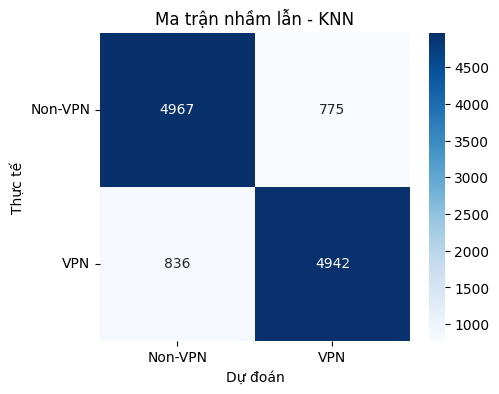

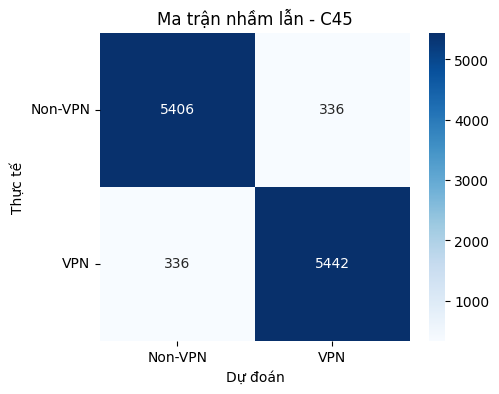

In [8]:
def plot_confusion(y_true, y_pred, name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Ma trận nhầm lẫn - {name}")
    plt.xlabel("Dự đoán")
    plt.ylabel("Thực tế")
    plt.xticks([0.5,1.5], ["Non-VPN","VPN"])
    plt.yticks([0.5,1.5], ["Non-VPN","VPN"], rotation=0)
    plt.show()

for name in results:
    plot_confusion(y_test, results[name]["y_pred"], name)

# 9. Biểu đồ so sánh mô hình

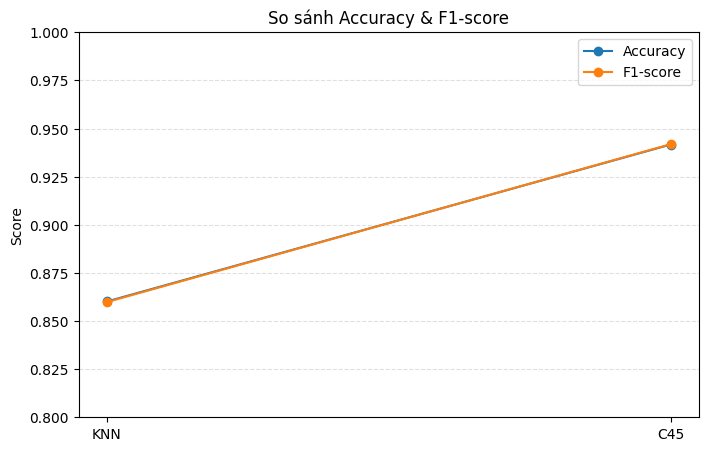

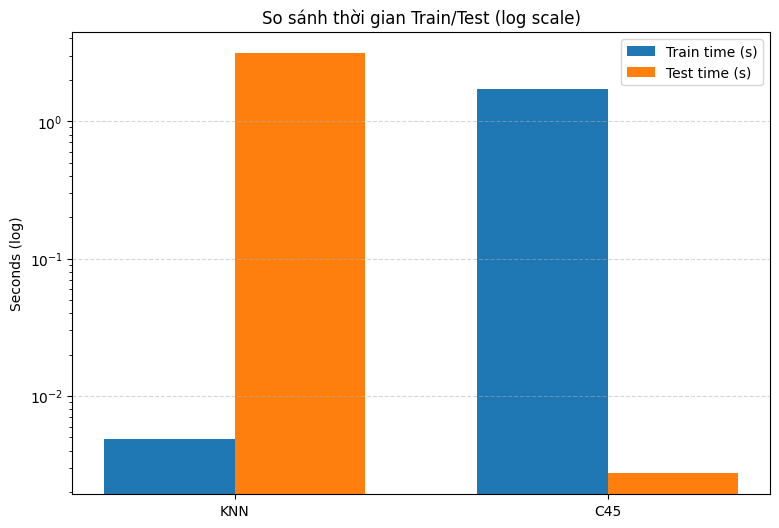

In [9]:
names = list(results.keys())
accs  = [results[n]["acc"] for n in names]
f1s   = [results[n]["f1"] for n in names]

plt.figure(figsize=(8,5))
plt.plot(names, accs, marker='o', label="Accuracy")
plt.plot(names, f1s, marker='o', label="F1-score")
plt.ylim(0.8, 1.0)
plt.title("So sánh Accuracy & F1-score")
plt.ylabel("Score")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


train_times = [results[n]["train_time"] for n in names]
test_times  = [results[n]["test_time"] for n in names]

x = np.arange(len(names))
width = 0.35

plt.figure(figsize=(9,6))
plt.bar(x - width/2, train_times, width, label="Train time (s)")
plt.bar(x + width/2, test_times, width, label="Test time (s)")
plt.xticks(x, names)
plt.yscale("log")
plt.title("So sánh thời gian Train/Test (log scale)")
plt.ylabel("Seconds (log)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 10. Bảng tổng hợp

In [10]:
summary = pd.DataFrame(results).T
summary = summary[['acc','f1','train_time','test_time']]
summary.columns = ['Accuracy','F1','Train_time_s','Test_time_s']

print("\n=== BẢNG TỔNG HỢP KẾT QUẢ ML BINARY ===")
print(summary)


=== BẢNG TỔNG HỢP KẾT QUẢ ML BINARY ===
     Accuracy        F1 Train_time_s Test_time_s
KNN  0.860156  0.859852     0.004909    3.120814
C45  0.941667  0.941848      1.70555    0.002742
